In [31]:
import skimage
import os
from skimage import io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import re
import numpy as np
import seaborn as sn
## for the stats class
import scipy.signal as sg
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.decomposition import SparsePCA
import pywt
from scipy import stats
import timeit 
#import optshrink as opt # package we create
import numpy as np
# import scipy.io as sio
import h5py
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import pandas as pd
from datetime import datetime
import pytz

In [2]:
### read in the transformed image data
file = "/home/smmrrr/Fog_Imaging_Project/images_flattened.csv"
flattened = np.genfromtxt(file, delimiter=',', skip_header=0, dtype=float, names=None)

In [42]:
## read in labels 
photo_links = pd.read_csv('/home/smmrrr/Fog_Imaging_Project/all_photos_link.csv')
photo_labels = pd.read_csv('/home/smmrrr/Fog_Imaging_Project/Holman_Labels_Attempt1.csv')
# photo_links
photo_labels.loc[0,'Url']
photo_labels['link'] = photo_labels['Url'].apply(lambda x: re.sub(r'AmlDatastore://workspaceblobstore/UI/2023-04-01_002812_UTC/label_image_data2/'
                                                  ,'',x))
# photo_links
links_and_labels = photo_links.merge(photo_labels, how = 'left', right_on = 'link', left_on = 'project_files_location')
links_and_labels['Label'] = links_and_labels['Label'].fillna('Not_Labeled')
image_files_summary = links_and_labels['project_files_location'].str.split(r'[\.|\_]',expand = True)
image_files_summary.columns = ['number_id', 'weekday', 'month_abv', 'day', 'hour', 'min', 'second', 'tz', 'year', 'camera', 'camera_angle', 'image_capture_type', 'ext']
# image_files_summary['filename'] = image_files

links_and_labels = pd.concat([links_and_labels, image_files_summary], axis = 1 )
links_and_labels['year'] = links_and_labels['year'].astype(int)
links_and_labels['day']=links_and_labels['day'].astype(int)
links_and_labels['hour']=links_and_labels['hour'].astype(int)
# links_and_labels['month']=links_and_labels.apply(lambda row: datetime.strptime(row['month_abv'], '%b').month)
# links_and_labels['month']=datetime.strptime(links_and_labels['month_abv'], '%b').month
links_and_labels['month']=links_and_labels['month_abv'].apply(lambda x: datetime.strptime(x, '%b').month)
links_and_labels['time'] = links_and_labels.apply(lambda row: datetime(row['year'], row['month'], row['day'], row['hour']), axis=1)



In [45]:

# Specify the original timezone (if different from system timezone)
original_timezone = pytz.timezone('GMT')

# Convert to Pacific Time
pacific_timezone = pytz.timezone('US/Pacific')
links_and_labels['time_pst'] = links_and_labels['time'].dt.tz_localize(original_timezone).dt.tz_convert(pacific_timezone)



In [46]:
links_and_labels

,project_files_location,photo_size,Url,Label,LabelConfidence,link,number_id,weekday,month_abv,day,...,second,tz,year,camera,camera_angle,image_capture_type,ext,month,time,time_pst
0,746574512.Sat.Aug.28_21_48_32.GMT.1993.argus00...,"(480, 640)",NaN,Not_Labeled,NaN,NaN,746574512,Sat,Aug,28,...,32,GMT,1993,argus00,c0,snap,jpg,8,1993-08-28 21:00:00,1993-08-28 14:00:00-07:00
1,905736605.Mon.Sep.14_01_30_05.GMT.1998.argus00...,"(480, 640, 3)",NaN,Not_Labeled,NaN,NaN,905736605,Mon,Sep,14,...,05,GMT,1998,argus00,c0,snap,jpg,9,1998-09-14 01:00:00,1998-09-13 18:00:00-07:00
2,1151780400.Sat.Jul.01_19_00_00.GMT.2006.argus0...,"(960, 1280, 3)",NaN,Not_Labeled,NaN,NaN,1151780400,Sat,Jul,1,...,00,GMT,2006,argus00,c0,snap,jpg,7,2006-07-01 19:00:00,2006-07-01 12:00:00-07:00
3,995580007.Thu.Jul.19_22_00_07.GMT.2001.argus00...,"(480, 640, 3)",NaN,Not_Labeled,NaN,NaN,995580007,Thu,Jul,19,...,07,GMT,2001,argus00,c0,snap,jpg,7,2001-07-19 22:00:00,2001-07-19 15:00:00-07:00
4,1560808800.Mon.Jun.17_22_00_00.GMT.2019.argus0...,"(960, 1280, 3)",NaN,Not_Labeled,NaN,NaN,1560808800,Mon,Jun,17,...,00,GMT,2019,argus00,c0,snap,jpg,6,2019-06-17 22:00:00,2019-06-17 15:00:00-07:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68967,802803635.Sat.Jun.10_17_00_35.GMT.1995.argus00...,"(480, 640)",NaN,Not_Labeled,NaN,NaN,802803635,Sat,Jun,10,...,35,GMT,1995,argus00,c0,snap,jpg,6,1995-06-10 17:00:00,1995-06-10 10:00:00-07:00
68968,1408485600.Tue.Aug.19_22_00_00.GMT.2014.argus0...,"(960, 1280, 3)",AmlDatastore://workspaceblobstore/UI/2023-04-0...,Foggy,1.0,1408485600.Tue.Aug.19_22_00_00.GMT.2014.argus0...,1408485600,Tue,Aug,19,...,00,GMT,2014,argus00,c0,snap,jpg,8,2014-08-19 22:00:00,2014-08-19 15:00:00-07:00
68969,842547625.Thu.Sep.12_17_00_25.GMT.1996.argus00...,"(480, 640)",NaN,Not_Labeled,NaN,NaN,842547625,Thu,Sep,12,...,25,GMT,1996,argus00,c0,snap,jpg,9,1996-09-12 17:00:00,1996-09-12 10:00:00-07:00
68970,966366006.Tue.Aug.15_19_00_06.GMT.2000.argus00...,"(480, 640, 3)",NaN,Not_Labeled,NaN,NaN,966366006,Tue,Aug,15,...,06,GMT,2000,argus00,c0,snap,jpg,8,2000-08-15 19:00:00,2000-08-15 12:00:00-07:00


In [4]:
#### "cloud sensitive image metrics"

##calculating luminescence 

##coefficient of variation (sigma over mu)
cv = flattened.std(axis = 1) / flattened.mean(axis = 1)
print(len(cv))

##michelsons contrast 
mc = (flattened.max(axis = 1)-flattened.min(axis = 1)) / (flattened.max(axis = 1)+flattened.min(axis = 1))
print(len(mc))

##
# H = stats.entropy(axis = 1)

68972
68972


In [6]:
kde_results = np.apply_along_axis(gaussian_kde, 1, flattened)
# len(kde_results)
# # Generate points to evaluate the KDE
x = np.linspace(np.min(flattened), np.max(flattened), 100)
H = [stats.entropy(kde.pdf(x)) for kde in kde_results]
print(len(H))
# # Calculate the normalized probabilities for each row
# probabilities = pdf_values / np.sum(pdf_values, axis=1)[:, np.newaxis]



68972


In [15]:
cv.reshape(68972,1).shape

(68972, 1)

In [18]:
image_data = np.concatenate((cv.reshape(68972,1), mc.reshape(68972,1), np.array(H).reshape(68972,1)), axis = 1)
image_data = pd.DataFrame(image_data, columns = ['cv','mc', 'H'])
image_data

,cv,mc,H
0,0.516831,1.000000,4.211455
1,0.522420,1.000000,3.976724
2,0.771450,0.960514,4.285766
3,0.485275,0.999434,4.352856
4,0.675499,0.864881,4.021617
...,...,...,...
68967,0.507761,1.000000,4.171144
68968,0.752299,0.925227,4.453622
68969,0.520303,1.000000,4.333830
68970,0.417823,1.000000,4.426923


In [27]:
labels = links_and_labels[['Label', 'project_files_location']]
plot_data = pd.concat([image_data, labels], axis = 1)
plot_data.loc[plot_data['Label'].isna(), 'Label'] = 'un-labeled'

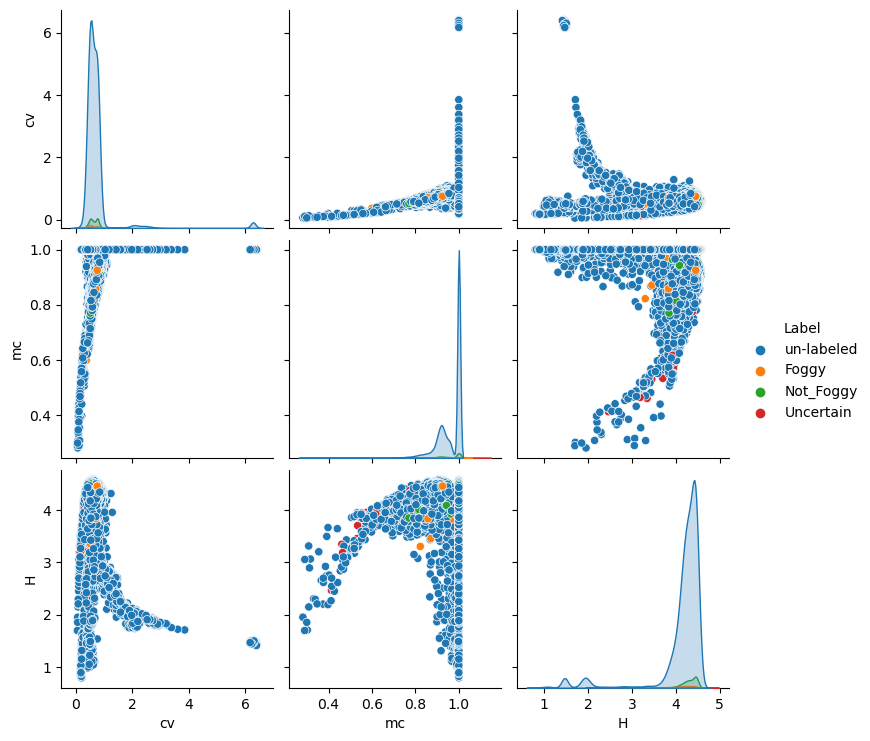

In [28]:
sns.pairplot(plot_data, hue = 'Label')